In [1]:
# Copyright 2024 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Next-Generation Astronomical Transient Classification via Large Language Models

<table align="left">
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/turanbulmus/spacehack/blob/main/01%20-%20Prompt%20Engineering.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Google Colaboratory logo"><br> Open in Colab
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/colab/import/https:%2F%2Fraw.githubusercontent.com%2Fturanbulmus%2Fspacehack%2Fmain%2F01%20-%20Prompt%20Engineering.ipynb">
      <img width="32px" src="https://lh3.googleusercontent.com/JmcxdQi-qOpctIvWKgPtrzZdJJK-J3sWE1RsfjZNwshCFgE_9fULcNpuXYTilIR2hjwN" alt="Google Cloud Colab Enterprise logo"><br> Open in Colab Enterprise
    </a>
  </td>    
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/turanbulmus/spacekhack/main/01%20-%20Prompt%20Engineering.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo"><br> Open in Workbench
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://github.com/turanbulmus/spacehack/blob/main/01%20-%20Prompt%20Engineering.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo"><br> View on GitHub
    </a>
  </td>
</table>

| Author(s) | turanbulmus
https://github.com/turanbulmus |

## Overview

This notebook showcases the potential of multimodal models like Gemini 1.5 Pro for tackling zero-shot object classification problems. We'll explore how this advanced model can analyze telescope images, compare them against reference and difference images, and classify them as "real" or "bogus" solely based on visual information and human-provided instructions. By the end of this notebook, you'll gain insights into:

* How Gemini 1.5 Pro can perform zero-shot classification tasks without explicit training.
* The power of multimodal models to understand and reason about visual content.
* Building effective prompts for complex image analysis tasks.

This notebook demonstrates the following steps:

1. **Import Libraries and Build Functions:** We start by importing the necessary libraries for image loading, processing, and evaluation. We also define functions to facilitate the analysis and visualization of results.
2. **Build System Instructions for the Prompt:** A well-crafted prompt is crucial for guiding Gemini 1.5 Pro towards the desired output. We carefully define instructions outlining the task, the type of images, and the desired classification outcome.
3. **Load the Dataset:** We load a collection of telescope images, including reference, difference, and new images, to be used for the classification task.
4. **Run Gemini 1.5 Pro with the Prompt:** We execute the prompt with Gemini 1.5 Pro, iterating over 100 samples from the dataset to get classifications for each image.
5. **Evaluate Model Performance:** We evaluate the model's performance using metrics like a confusion matrix, precision, recall, and accuracy. These metrics provide insights into the model's ability to correctly classify "real" and "bogus" images. Finally, we visualize the results for better understanding.

## Getting Started

### Install Vertex AI SDK and other required packages

In [2]:
! pip install -r requirements.txt --quiet


[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: pip install --upgrade pip


### Restart runtime

To use the newly installed packages in this Jupyter runtime, you must restart the runtime. You can do this by running the cell below, which restarts the current kernel.

The restart might take a minute or longer. After it's restarted, continue to the next step.

In [3]:
# import IPython

# app = IPython.Application.instance()
# app.kernel.do_shutdown(True)

<div class="alert alert-block alert-warning">
<b>⚠️ The kernel is going to restart. Please wait until it is finished before continuing to the next step. ⚠️</b>
</div>

### Authenticate your notebook environment

If you're using Colab, run the code in the next cell. Follow the popups and authenticate with an account that has access to your Google Cloud [project](https://cloud.google.com/resource-manager/docs/creating-managing-projects#identifying_projects).

If you're running this notebook somewhere besides Colab, make sure your environment has the right Google Cloud access. If that's a new concept to you, consider looking into [Application Default Credentials for your local environment](https://cloud.google.com/docs/authentication/provide-credentials-adc#local-dev) and [initializing the Google Cloud CLI](https://cloud.google.com/docs/authentication/gcloud). In many cases, running `gcloud auth application-default login` in a shell on the machine running the notebook kernel is sufficient.

More authentication options are discussed [here](https://cloud.google.com/docs/authentication).

In [4]:
import sys

if "google.colab" in sys.modules:
    from google.colab import auth

    auth.authenticate_user()
    print('Authenticated')

### Set Google Cloud project information and initialize Vertex AI SDK

To get started using Vertex AI, you must have an existing Google Cloud project and [enable the Vertex AI API](https://console.cloud.google.com/flows/enableapi?apiid=aiplatform.googleapis.com).

Learn more about [setting up a project and a development environment](https://cloud.google.com/vertex-ai/docs/start/cloud-environment).

In [5]:
PROJECT_ID = "turan-genai-bb"  # @param {type:"string"}
LOCATION = "us-central1"  # @param {type:"string"}

import vertexai

vertexai.init(project=PROJECT_ID, location=LOCATION)

## Import libraries and define helper functions

In [6]:
import gdown 
import base64
import json
import random
import time
from pathlib import Path

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from vertexai.generative_models import GenerativeModel, Part, FinishReason, Image
import vertexai.preview.generative_models as generative_models
from google.cloud import bigquery

In [7]:
generation_config = {
    "max_output_tokens": 2048,
    "temperature": 0.7,
    "top_p": 1,
    "top_k": 32,
    "response_mime_type": "application/json",
}

safety_settings = {
    generative_models.HarmCategory.HARM_CATEGORY_HATE_SPEECH: generative_models.HarmBlockThreshold.BLOCK_NONE,
    generative_models.HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT: generative_models.HarmBlockThreshold.BLOCK_NONE,
    generative_models.HarmCategory.HARM_CATEGORY_SEXUALLY_EXPLICIT: generative_models.HarmBlockThreshold.BLOCK_NONE,
    generative_models.HarmCategory.HARM_CATEGORY_HARASSMENT: generative_models.HarmBlockThreshold.BLOCK_NONE,
}

def generate(model, prompt):
  """Generates text based on the provided prompt using a Gemini model.

  Args:
    prompt: The text prompt to use for generating text.

  Returns:
    A list of responses generated by the model.

  Raises:
    Exception: If there is an error generating content.
"""
  # Generate content using the specified prompt and configurations.
  responses = model.generate_content(
      prompt,
      generation_config=generation_config,# Configuration for text generation
      safety_settings=safety_settings,# Settings for safety checks during generation
      stream=False,# Set to False to retrieve all generated content at once
  )
  # Return the generated responses.
  return responses

def create_ex(data_index):
  """
    Loads and returns a list containing strings and images to be used for Gemini for a given data index.

    Args:
        data_index (int): The index of the data set to load.

    Returns:
        list: A list containing strings and images. The list contains:
            - "new image: "
            - Image object loaded from "pics/Example_{data_index}_fig_0.png"
            - "reference image: "
            - Image object loaded from "pics/Example_{data_index}_fig_1.png"
            - "difference image: "
            - Image object loaded from "pics/Example_{data_index}_fig_2.png"
    """   
  str_new = "new image: " # String for labeling the new image
  str_ref = "reference image: " # String for labeling the reference image
  str_dif = "difference image: " # String for labeling the difference image

  # Load images from files using the given data index
  image1 = Part.from_image(Image.load_from_file(f"pics/Example_{data_index}_fig_0.png"))
  image2 = Part.from_image(Image.load_from_file(f"pics/Example_{data_index}_fig_1.png"))
  image3 = Part.from_image(Image.load_from_file(f"pics/Example_{data_index}_fig_2.png"))
  
  # Return the list containing strings and images
  return [str_new, image1, str_ref, image2, str_dif, image3]

def preprocess(dataset, index_no):
  """Preprocesses a pair of images from a dataset for analysis.
  This function takes a multi-dimensional array containing image data, a corresponding array of labels, and an index. It then:

  1. **Combines** the real and reference images at the specified index.
  2. **Normalizes** the combined image to a range of 0-255.
  3. **Separates** the normalized image back into real and reference images.
  4. **Calculates** the difference image between the reference and real images.
  5. **Returns** the real image, reference image, difference image, and the label associated with the index.

  Args:
    dataset: A multi-dimensional array containing image data. Each element is expected to be a 4-dimensional array representing a pair of images (real and reference).
    index_no: The index of the image pair to be processed.

  Returns:
    A tuple containing:
      - real_image: A 2D array representing the real image.
      - ref_image: A 2D array representing the reference image.
      - diff_image: A 2D array representing the difference between the reference and real images.
      - label: The label associated with the processed image pair.
  """
  #Combine the real image and the reference image 
  comb_im = np.append(dataset[index_no, 0:100, 0:100,0], dataset[index_no, 0:100, 0:100,1])
  #Normalize the combined image wirh clipping to 2% and 98%
  p2 = np.percentile(comb_im, 2)
  p98 = np.percentile(comb_im, 98)
  comb_im[comb_im < p2] = p2
  comb_im[comb_im > p98] = p98
  norm_comb_im = 255 * (comb_im - p2) / (p98 - p2)

  # Separate the array back and calculate the difference image
  real_image = np.reshape(norm_comb_im[0:100*100], (100,100))
  ref_image = np.reshape(norm_comb_im[100*100:], (100,100))
  diff_image = np.subtract(ref_image, real_image)    

  # Return the real image, the reference image and the difference image and the label
  return [real_image, ref_image, diff_image]

def save_picture(dataset, index_no):
# Save the images as png
  processed_im = preprocess(dataset, index_no)
  plt.ioff()
  for j in range(3):
      plt.imshow(processed_im[j],cmap='gray')
      plt.axis('off')
      plt.savefig(f"pics/Example_{index_no}_fig_{j}_newtry.png")
  plt.ion()

def batch_data_create(stat_prompt, dyna_prompt):
  return  json.dumps({
    "contents": [
      {
        "role": "user",
        "parts": {
          "text": f"{dyna_prompt}"
        }
      }
    ],
    "system_instruction": {
      "parts": [
        {
          "text": f"{stat_prompt}"
        }
      ]
    }
  })

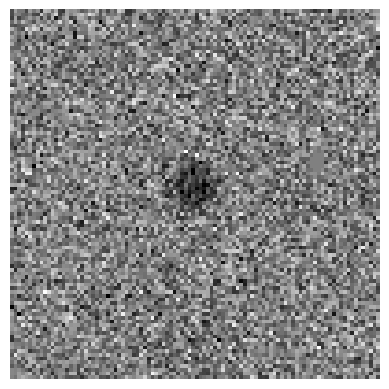

In [8]:
# Prompt examples Build
# The location of the quadruplets of images and the labels
# TODO: @Fiorenzo to add data open source license
quad_im = Path("data/collected_ims.npy")
lab = Path("data/collected_vet.npy")
if not(quad_im.is_file()) and not(lab.is_file()):
    id = "1Gb0KKqNEPskOC3ognXF5K9eyFnpZhMpY" #id of the collected_ims.npy
    gdown.download(id=id, output = quad_im)
    id =  "1QmyR4XCdT9SLCP-7yvNsbooPt9r7HIKs" #id of the collected_vet.npy
    gdown.download(id=id, output = lab)

# Load the .npy files containing the quadruplets of images and labels
quadruplets = np.load(quad_im) #Load quadruplets of images
labels = np.load(lab) # Load the labels



labels_df = pd.DataFrame(labels, columns=['label'])
labels_df['label'] = labels_df['label'].apply(lambda x: 'Real' if x > 0.5 else 'Bogus')

# Sample indexes you want to access
sample_indexes= [1, 14, 16, 18, 28, 29]

for i in sample_indexes:
    save_picture(quadruplets, i)

In [9]:
## DESCRIPTION INDEX 1:
desc1 = {
  "class": "Bogus",
  "explanation": "In the New image the source is a streak of few really bright pixels and not point source-like. No source at the same location in the Reference image. This is too sharp to be a real source and most likely a cosmic ray."
}

## DESCRIPTION INDEX 14:
desc2= {
  "class": "Bogus",
  "explanation": "In the New image the source appears as a negative ring, and therefore this cannot be real. It is most likely a lump of dead pixels that have gone unflagged. The presence of other dead pixels also in the Reference image confirms that this is likely a Bogus." 
}

## DESCRIPTION INDEX 16:
desc3 = {
  "class": "Real",
  "explanation": "In the New image the central source visible in the Reference image has completely disappeared. This leaves a negative, point-source-like object in the Difference image, as expected from a variable star that got significantly dimmer."
}

## DESCRIPTION INDEX 18:
desc4 = {
  "class": "Real",
  "explanation": "The source is present at the same location in both the New and Reference images. The Difference image shows a positive residual signifying that the source has brightened."
}

## DESCRIPTION INDEX 28:
desc5 = {
  "class": "Bogus",
  "explanation": "No source in the New image. The Reference image has a negative artefact, therefore this is not a real source. A negative artefact in the Reference image often produces a positive source in the Difference image, but this is Bogus since the source can never be negative in the New and/or Reference image."
}

## DESCRIPTION INDEX 29:
desc6 = {
  "class": "Real",
  "explanation": "There is a bright source, point-like, that has appeared in the New image, without any source being present in the Difference image at the same location. It is also a point source in the Difference image, as expected from a real transient."
}

descriptions = [str(desc1), str(desc2), str(desc3), str(desc4), str(desc5), str(desc6)]

In [10]:
PERSONA = ["""<PERSONA>
You are an experienced astrophysicist and your task is to classify the given set of 3 images is real or bogus. You have seen thousands of images during your life time and you are very good at making this classification by look at the images and following the instructions. 
</PERSONA>"""]
INSTRUCTIONS = ["""\n<INSTRUCTIONS>
**1. Purpose**
This is meant as a visual guide to vetting MeerLICHT/BlackGEM data for the Real/Bogus classification. At this stage we are trying to get a high-fidelity machine learning network of what is real and what is bogus. As such it is not necessary to further classify what type of real or what type of bogus it is. But what is real and what is bogus?

**2. Real: Any source that is of astrophysical origin, and variable in time and/or position.**
A real source therefore:
a) has a shape that reflects a **point-source**. Most MeerLICHT data is taken in decent focus conditions, so for us it means that the source is **round**, and has a (visual) extent of ~5-10 pixels. Because conditions vary this number also varies, also between the new and the reference image.
b) is **positive** in either the new or the reference image.
c) can be **variable** in both directions, e.g. fading or brightening between the new and reference image, and is therefore positive or negative in the difference image 
d) can **(dis)appear** between the new and the reference image. This means that in one of the two images there is no source at all, and in the other there is a clear point-source. Note that this can happen on top of an underlying galaxy.

What is the difference between a transient and a variable?
This is a long-standing and fluid debate. For the moment we will adopt the following distinction:
a) a **transient** is an object **with no underlying quiescent point-source counterpart** in the reference image.
b) a **variable** is an object with **an underlying quiescent point-source counterpart** in the reference image.
This is a phenomenological distinction based solely on our own data, not an astrophysical distinction.
E.g. we would all consider a supernova to be a transient (i.e. a destructive, non-repeating, once-offevent). However, in deep images it may have an underlying counterpart (the original star). Or it was detected while bright in the reference image and therefore all the new images shows it to be fading, i.e. a variable.
On the other hand, we can have a dwarf nova outburst occuring in a Cataclysmic Variable with a counterpart that is below our detection limit. Eventhough astrophysically most people would classify a dwarf nova outburst as a variable (i.e. a non-destructive, repeating event), in our data it will look like a transient.
Without any additional information (light curves, deeper images, spectra) we will not be able to make a distinction between these. However, for our real-bogus classification this doesn’t matter. Both are **real**."

**3. Bogus: Any source that is not of astrophysical origin**
Bogus sources are those that are not of astrophysical origin but artefacts, caused by the detector, cosmic-rays, reflections, or the data processing.
A bogus source therefore generally has:
a) a shape that is **not a point-source**: not round, not ‘Gaussian’, with a size ≾5 pixels or ≿10 pixels. Note that a ‘point’ (i.e. one bright pixel), is not a point-source.
b) is **negative** in either the new or the reference image. Any real source needs to show a positive image, i.e. countrates higher than the background sky.

**4. Information provided**
All vetters will be shown three images that are cut-outs of the science images around the suspected source. Therefore it is important to note that **the candidate transient lies in the center of the cut-outs**. Use the full 100x100 pixel image to base your judgement on. If you see that the transient candidate has a very different psf than other stars in the image; or if the image is extended and very close to the edge (possibly a reflection): use this information in your judgement.

The three images are:
1) The **new** image, i.e. the latest science image. This is fully reduced, i.e. debiased and flatfielded.
2) The **reference** image, against which the new image is compared. For the moment the reference images are simply the first image that was taken of a field. The depth and image quality of the reference image therefore does not have to be better/deeper than that of the new image. 
3) The **difference** image. This is the image that is the residual after the new and reference image are  subtracted from each other after being sky-subtracted and scaled/convolved to have matching point- spread-functions. Variations in sky background and seeing should therefore not show up in the difference image. Reals should show up as a point-source object with either positive or negative flux. Residuals due to an imperfect astrometric regridding can still show up. These will generally be seen as ‘ying-yang’ patterns of positive/negative flux. 
</INSTRUCTIONS>

"""]

In [11]:
# Report 3 Real and 3 Bogus examples for the prompt
EXAMPLES = ["<EXAMPLES>\n"]
for i in range(len(sample_indexes)):
    
    str_EX = f"""Example {i+1}:
    """
    all_list = create_ex(sample_indexes[i])
    all_list.insert(0, str_EX)
    all_list.append(descriptions[i])
    all
    for k in all_list:
        EXAMPLES.append(k)
EXAMPLES.append("\n</EXAMPLES>\n")
TASK = ["""<TASK>
Your task is to read the INSTRUCTIONS and look at the 3 images, classify if these 3 images to be Real or Bogus. Provide your thought process to explain how you reasoned to provide the response. Respond in json format
</TASK>\n
"""]

In [12]:
METHOD = ["""<METHOD>
Do not simply provide a binary classification. Utilize your knowledge, the provided guide, and the image data to generate a comprehensive explanation for your classification.

Employ a chain-of-thought process, clearly outlining each step of your analysis.
Analyze each image individually and in relation to each other.
For each feature you examine (shape, flux, etc.), describe your observations and how they contribute to your classification.
If you observe features from the images described in the <INSTRUCTIONS> section, clearly identify them and relate them to your reasoning.
If any of your observations contradict a potential classification, acknowledge the discrepancy and justify your final decision.
</METHOD>
"""]

In [13]:
stat_prompt = []
stat_prompt.extend(PERSONA + INSTRUCTIONS + EXAMPLES + METHOD +TASK) 
# Initialize the generative model with the desired model name.
model = GenerativeModel("gemini-1.5-pro-001") 

In [14]:
pred_df = pd.DataFrame(columns=["label", "prediction", "explanation"])

#table_id = "turan-genai-bb.spacehack.batch_input"
#bq_client = bigquery.Client()
#table = bq_client.get_table(table_id)
random.seed(74)
for t in random.sample(range(17001), 100):

    save_picture(quadruplets, t)
    dyna_prompt = create_ex(t)
    #row = [{"request": batch_data_create(stat_prompt, dyna_prompt)}]
    #errors = bq_client.insert_rows_json(table, row)
    #if errors == []:
    #    print("success")
    response = json.loads(generate(model, stat_prompt + dyna_prompt).text)
    time.sleep(8)
    pred_df.loc[t] = [labels_df['label'][t], response['class'], response['explanation']]

<Figure size 640x480 with 0 Axes>

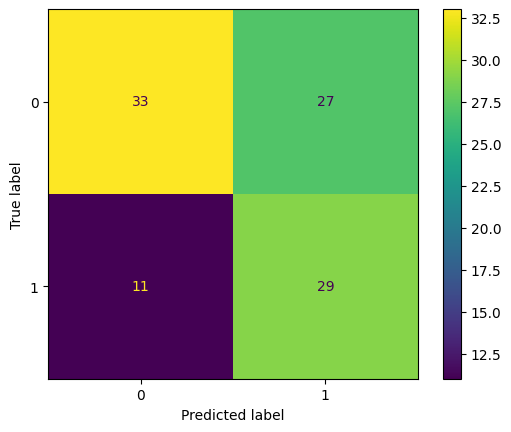

In [15]:
#Save the predictions
pred_df.to_csv("pred3.csv")
#pred_df=pd.read_csv("pred3.csv")
plt.clf()
cm = confusion_matrix(pred_df.label, pred_df.prediction)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [16]:
TP = cm[0][0]
TN = cm[1][1]
FP = cm[0][1]
FN = cm[1][0]
print(f"Accuracy is {(TN+TP)/(TN+TP+FP+FN)}")
print(f"Precision is {TP/(TP+FP)}")
print(f"Recall is {TP/(TP+FN)}")

Accuracy is 0.62
Precision is 0.55
Recall is 0.75
